# Polyphase Filter-Bank Inversion Temporal Fidelity Notebook

This notebook demonstrates using the `PyDADA` library to analyse files that have been produced by `DSPSR` that includes
polyphase filter-bank (PFB) inverted data.

The `PyDADA` library currently only supports 1 output channel (`NCHAN=1`) and 1 polarisation (`NPOL=1`)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pprint

import matplotlib.pyplot as plt
import numpy as np

from ska_pydada import DadaFile
from ska_pydada.utils.pfb_analysis import TemporalFidelityResult, analyse_pfb_temporal_fidelity

## Example of processing valid PFB data

The following cells demonstrate using the `analyse_pfb_temporal_fidelity` from `PyDADA` to get
a result dataclass instance (`TemporalFidelityResult`) and how to use that dataclass.

The output file from `DSPSR` provides complex floating point data in temporal, frequency and polarisation order (TFP). This particular file had the number of inverse fast Fourier transform (IFFT) bins as `196608`.

For SKA Low the requirements are as follows:

### Maximum Temporal Leakage 

* the slope ***m*** of the maximum allowable relative power envelope centred on each impulse of −4 dB/μs
* the halfwidth ***W*** of each envelope 15 μs
* maximum allowable relative power beyond the envelope centred on each impulse with ***Xmax*** = -60 dB

### Total Temporal Leakage

* the halfwidth ***W*** of each envelope is 15 μs
* maximum allowable total spurious power integrated over all time samples beyond the envelope centred on each impulse, relative to the peak is ***Smax*** = -50 dB

### Python API to analyse file

The Python method `analyse_pfb_temporal_fidelity` takes the following:

* a file path (relative or absolute and can be a `pathlib.Path` object too)
* `NIFFT` using the `nifft` argument
* the ***m*** slope using the `env_slope_db` argument
* the ***W*** halfwidth using the `env_halfwidth_us` argument
* the ***Xmax*** using the `max_db_outside_env` argument
* the ***Smax*** using the `max_spurious_power_db` argument

It also has 2 optional arguments, one of which must be set but if both are set they must be consistent.

* the number of pulses to analyse (the `num_pulses` argument)
* a list of expected time sample / index of where a pulse is expected (the `expected_impulses` argument)

In [3]:
NIFFT = 196608  # if DSPSR added this in the header the value could come from that file
SKA_LOW_M = -4.0
SKA_LOW_W = 15.0
SKA_LOW_X_MAX = -60.0
SKA_LOW_S_MAX = -50.0

### Perfom analysis on a file that should pass

#### Inspect the DADA file data directly

In the following cells we look at the data directly without calling `analyse_pfb_temporal_fidelity` this can be used to visualise if there are issues

In [4]:
pass_file = DadaFile.load_from_file("data/temporal_fidelity_pass.dada")

In [5]:
# print the header
pass_file.header

AsciiHeader([('HDR_VERSION', '1.000000'),
             ('TELESCOPE', 'PKS'),
             ('RECEIVER', 'unknown'),
             ('SOURCE', 'TestTemporal'),
             ('MODE', 'CAL'),
             ('CALFREQ', '0.000000'),
             ('FREQ', '300.000000'),
             ('BW', '200.000000'),
             ('NCHAN', '1'),
             ('NPOL', '1'),
             ('NBIT', '32'),
             ('NDIM', '2'),
             ('STATE', 'Analytic'),
             ('TSAMP', '1.080000'),
             ('UTC_START', '2019-02-05-01:15:49'),
             ('OBS_OFFSET', '196608'),
             ('INSTRUMENT', 'dspsr'),
             ('OS_FACTOR', '4/3'),
             ('PFB_DC_CHAN', '1'),
             ('HDR_SIZE', '4096')])

In [6]:
# Get the data in TFP, it is flattened as we have NCHAN = 1 and NPOL = 1
tfp_data = pass_file.as_time_freq_pol().flatten()

In [7]:
# complex data needs and needs to be power
tfp_data_power = np.abs(tfp_data) ** 2.0

max_id = np.argmax(tfp_data_power)

# we want relative power
tfp_data_power = tfp_data_power / tfp_data_power[max_id]

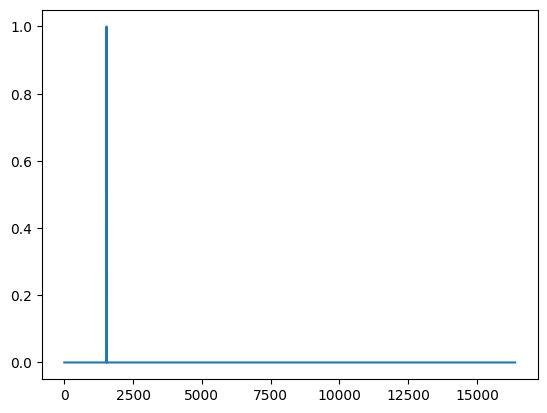

In [8]:
plt.plot(tfp_data_power[:16384])
plt.show()

In [9]:
# Easier to check using dB scale
tfp_data_power[tfp_data_power < 1e-10] = 1e-10

# relative power in dB
tfp_data_db = 10.0 * np.log10(tfp_data_power)

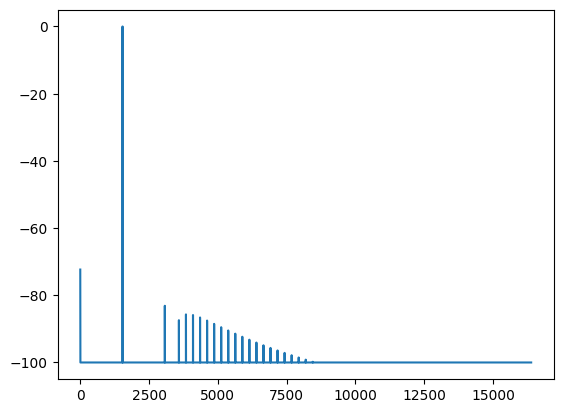

In [10]:
plt.plot(tfp_data_db[:16384])
plt.show()

#### Use the PyDADA analyse_pfb_temporal_fidelity function to do analysis

The following cells show how to use `analyse_pfb_temporal_fidelity` to do the analysis and to easily check if the file passes the SKA PFB inversion requirements

In [11]:
expected_to_pass: TemporalFidelityResult = analyse_pfb_temporal_fidelity(
    "data/temporal_fidelity_pass.dada",
    nifft=NIFFT,
    env_slope_db=SKA_LOW_M,
    env_halfwidth_us=SKA_LOW_W,
    max_db_outside_env=SKA_LOW_X_MAX,
    max_spurious_power_db=SKA_LOW_S_MAX,
    num_impulses=2,
    expected_impulses=[1536, 173664],
)

The output of the result can be printed as follows.

In the case of this file one can see that the `overall_result` is `True` (i.e. valid) and for each impulse there is a result which both have the following:

* the impulse and the expected impulse are at the same temporal index
* the `max_power_result` is `True` (i.e. valid)
* the `total_spurious_power_result` is `True` (i.e. valid)
* the `total_spurious_power_db` is <= -60 dB

In [12]:
pprint.pprint(expected_to_pass)

TemporalFidelityResult(tsamp=1.08,
                       overall_result=True,
                       impulse_results=[TemporalFidelityImpulseResult(impulse_idx=1536,
                                                                      expected_impulse_idx=1536,
                                                                      valid_impulse_position=True,
                                                                      max_power_result=True,
                                                                      total_spurious_power_result=True,
                                                                      total_spurious_power_db=-70.8338212966919,
                                                                      overall_result=True),
                                        TemporalFidelityImpulseResult(impulse_idx=173664,
                                                                      expected_impulse_idx=173664,
                                              

Perform the assertions to ensure that we have the correct impulse index and assert max temporal leakage and total spurious leakage

In [13]:
expected_impulses = [1536, 173664]

assert expected_to_pass.overall_result, "expected file to pass temporal fidelity analysis"

for expected_impulse_idx, r in zip(expected_impulses, expected_to_pass.impulse_results):
    assert r.expected_impulse_idx == expected_impulse_idx
    assert r.impulse_idx == expected_impulse_idx
    assert r.valid_impulse_position
    assert r.max_power_result
    assert len(r.max_power_result_idx) == 0
    assert r.total_spurious_power_result
    assert r.total_spurious_power_db <= SKA_LOW_S_MAX

The `TemporalFidelityImpulseResult` has some extra attributes that can be used to show what it has calculated.

The following cells shows the maximum expected power masks for the 2 different impulses (trimmed to +-128 time samples from the impulse)

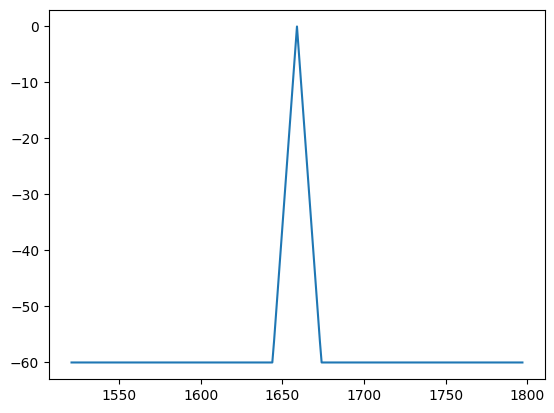

In [14]:
expected_max_power_db = expected_to_pass.impulse_results[0].expected_max_power_db
max_idx = expected_to_pass.impulse_results[0].expected_impulse_idx
idx_range = np.arange(max_idx - 128, max_idx + 128 + 1)
time = expected_to_pass.tsamp * idx_range

plt.plot(time, expected_max_power_db[idx_range])
plt.show()

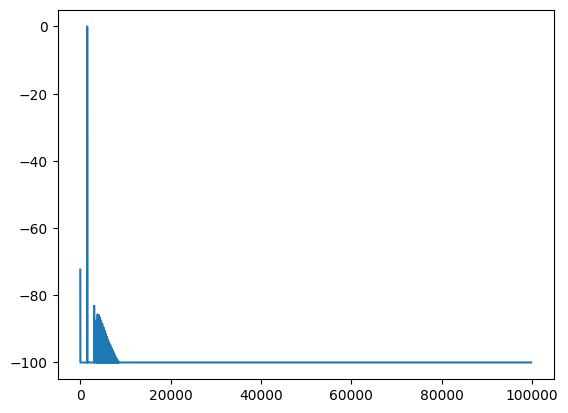

In [15]:
plt.plot(expected_to_pass.impulse_results[0].signal_power_db)
plt.show()

The following plot shows the same data as the manual analysis

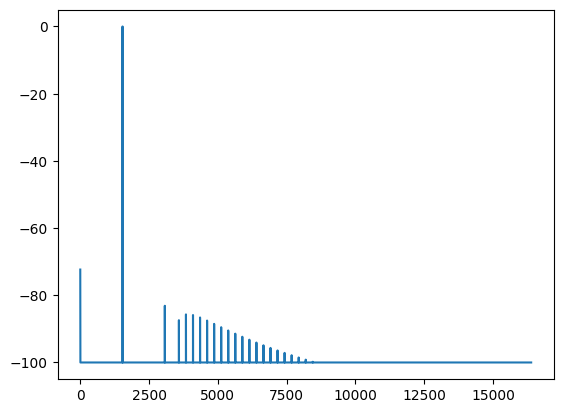

In [16]:
plt.plot(expected_to_pass.impulse_results[0].signal_power_db[:16384])
plt.show()

Plot the second impulse

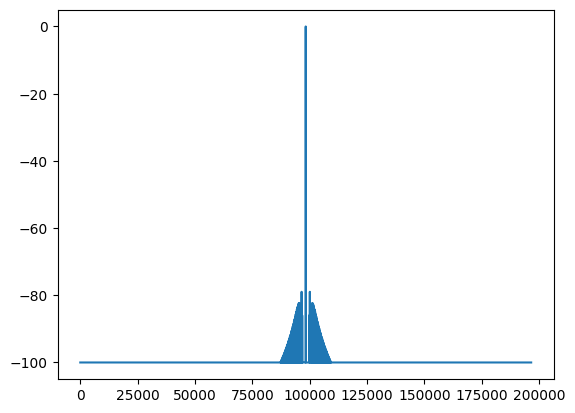

In [17]:
plt.plot(expected_to_pass.impulse_results[1].signal_power_db)
plt.show()

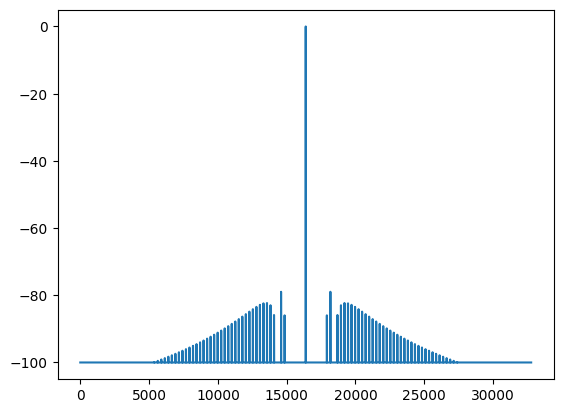

In [18]:
max_id = np.argmax(expected_to_pass.impulse_results[1].signal_power_db)

plt.plot(expected_to_pass.impulse_results[1].signal_power_db[max_id - 16384 : max_id + 16384])
plt.show()

### Perform analysis on a file that should fail

#### Inspect the DADA file data directly

In the following cells we look at the data directly without calling `analyse_pfb_temporal_fidelity` this can be used to visualise if there are issues

In [19]:
fail_file = DadaFile.load_from_file("data/temporal_fidelity_fail.dada")

In [20]:
fail_file.header

AsciiHeader([('HDR_VERSION', '1.000000'),
             ('TELESCOPE', 'PKS'),
             ('RECEIVER', 'unknown'),
             ('SOURCE', 'TestTemporal'),
             ('MODE', 'CAL'),
             ('CALFREQ', '0.000000'),
             ('FREQ', '300.000000'),
             ('BW', '200.000000'),
             ('NCHAN', '1'),
             ('NPOL', '1'),
             ('NBIT', '32'),
             ('NDIM', '2'),
             ('STATE', 'Analytic'),
             ('TSAMP', '1.080000'),
             ('UTC_START', '2019-02-05-01:15:49'),
             ('OBS_OFFSET', '196608'),
             ('INSTRUMENT', 'dspsr'),
             ('OS_FACTOR', '4/3'),
             ('PFB_DC_CHAN', '1'),
             ('HDR_SIZE', '4096')])

In [21]:
tfp_data_fail = fail_file.as_time_freq_pol().flatten()

In [22]:
tfp_data_fail_power = np.abs(tfp_data_fail) ** 2.0
tfp_data_fail_power_idx = np.argmax(tfp_data_fail_power)
tfp_data_fail_power = tfp_data_fail_power / tfp_data_fail_power[np.argmax(tfp_data_fail_power)]

Plot the relative power (not in dB), it is noticeable that there seems to be some leakage

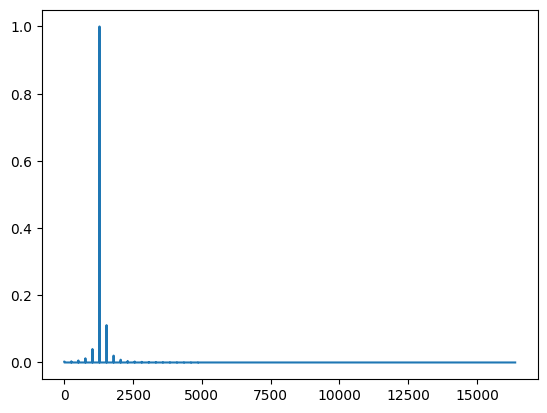

In [23]:
plt.plot(tfp_data_fail_power[:16384])
plt.show()

In [24]:
# Easier to check using dB scale
tfp_data_fail_power[tfp_data_fail_power < 1e-10] = 1e-10

# relative power in dB
tfp_data_fail_db = 10 * np.log10(tfp_data_fail_power)

Plotting relative power in dB shows the leakage

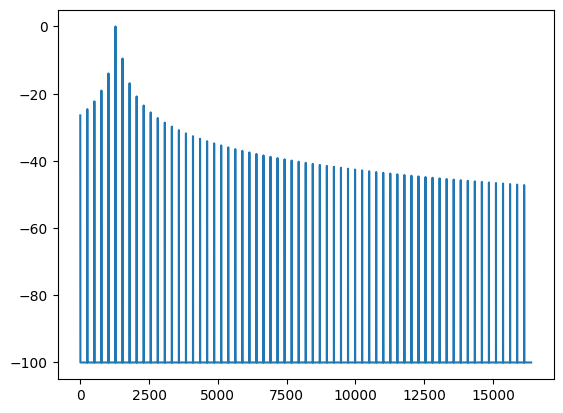

In [25]:
plt.plot(tfp_data_fail_db[:16384])
plt.show()

#### Use the PyDADA analyse_pfb_temporal_fidelity function to do analysis

The following cells show how to use `analyse_pfb_temporal_fidelity` to do the analysis and to easily check if the file passes the SKA PFB inversion requirements

In [26]:
expected_to_fail = analyse_pfb_temporal_fidelity(
    "data/temporal_fidelity_fail.dada",
    nifft=196608,
    env_slope_db=-4.0,
    env_halfwidth_us=15.0,
    max_db_outside_env=-60.0,
    max_spurious_power_db=-50.0,
    expected_impulses=[1280, 173408],
)

In [27]:
pprint.pprint(expected_to_fail)

TemporalFidelityResult(tsamp=1.08,
                       overall_result=False,
                       impulse_results=[TemporalFidelityImpulseResult(impulse_idx=1280,
                                                                      expected_impulse_idx=1280,
                                                                      valid_impulse_position=True,
                                                                      max_power_result=False,
                                                                      total_spurious_power_result=False,
                                                                      total_spurious_power_db=-6.519467830657959,
                                                                      overall_result=False),
                                        TemporalFidelityImpulseResult(impulse_idx=173408,
                                                                      expected_impulse_idx=173408,
                                         

Perform the assertions to ensure that we have the correct impulse index and assert max temporal leakage and total spurious leakage

In this case we will need to assert that max temporal leakage and total spurious power fail as the file itself was set up to fail

In [28]:
expected_impulses = [1280, 173408]

assert not expected_to_fail.overall_result, "expected file to fail temporal fidelity analysis"

for expected_impulse_idx, r in zip(expected_impulses, expected_to_fail.impulse_results):
    assert r.expected_impulse_idx == expected_impulse_idx
    assert r.impulse_idx == expected_impulse_idx
    assert r.valid_impulse_position
    # expect some samples to exceed the max power allowed
    assert not r.max_power_result
    assert len(r.max_power_result_idx) > 0
    # expect the total spurious power to be > -50dB
    assert not r.total_spurious_power_result
    assert r.total_spurious_power_db > SKA_LOW_S_MAX

One can check to see what indices have power outside of the allowed temporal leakage

In [29]:
expected_to_fail.impulse_results[0].max_power_result_idx

array([    0,   256,   512,   768,  1024,  1536,  1792,  2048,  2304,
        2560,  2816,  3072,  3328,  3584,  3840,  4096,  4352,  4608,
        4864,  5120,  5376,  5632,  5888,  6144,  6400,  6656,  6912,
        7168,  7424,  7680,  7936,  8192,  8448,  8704,  8960,  9216,
        9472,  9728,  9984, 10240, 10496, 10752, 11008, 11264, 11520,
       11776, 12032, 12288, 12544, 12800, 13056, 13312, 13568, 13824,
       14080, 14336, 14592, 14848, 15104, 15360, 15616, 15872, 16128,
       16384, 16640, 16896, 17152, 17408, 17664, 17920, 18176, 18432,
       18688, 18944, 19200, 19456, 19712, 19968, 20224, 20480, 20736,
       20992, 21248, 21504, 21760, 22016, 22272, 22528, 22784, 23040,
       23296, 23552, 23808, 24064, 24320, 24576, 24832, 25088, 25344,
       25600, 25856, 26112, 26368, 26624, 26880, 27136, 27392, 27648,
       27904, 28160, 28416, 28672, 28928, 29184, 29440, 29696, 29952,
       30208, 30464, 30720, 30976, 31232, 31488, 31744, 32000, 32256,
       32512, 32768,

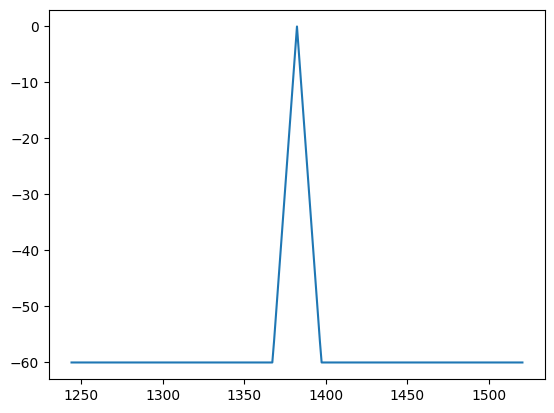

In [30]:
expected_max_power_db = expected_to_fail.impulse_results[0].expected_max_power_db
max_idx = expected_to_fail.impulse_results[0].expected_impulse_idx
idx_range = np.arange(max_idx - 128, max_idx + 128 + 1)
time = expected_to_fail.tsamp * idx_range

plt.plot(time, expected_max_power_db[idx_range])
plt.show()

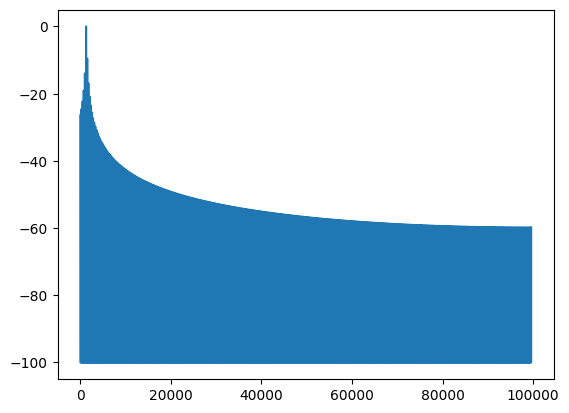

In [31]:
plt.plot(expected_to_fail.impulse_results[0].signal_power_db)
plt.show()

The following plot is the same from the above manual analysis

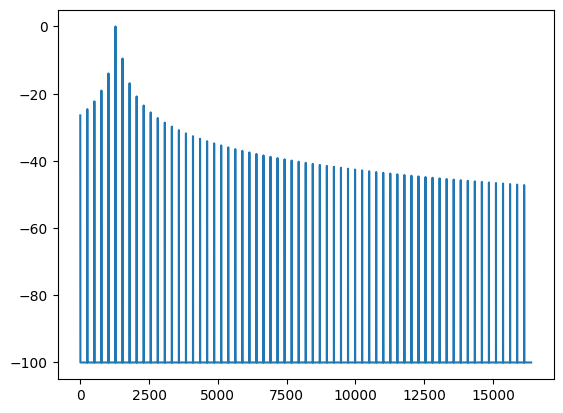

In [32]:
plt.plot(expected_to_fail.impulse_results[0].signal_power_db[:16384])
plt.show()

View the 2nd impulse. It is very noticeable from the dB plot that there are issues with the signal

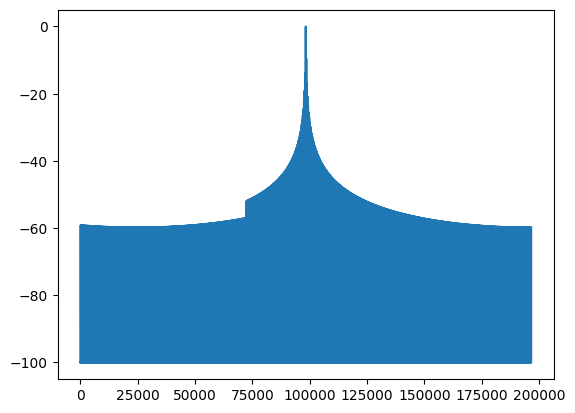

In [33]:
plt.plot(expected_to_fail.impulse_results[1].signal_power_db)
plt.show()

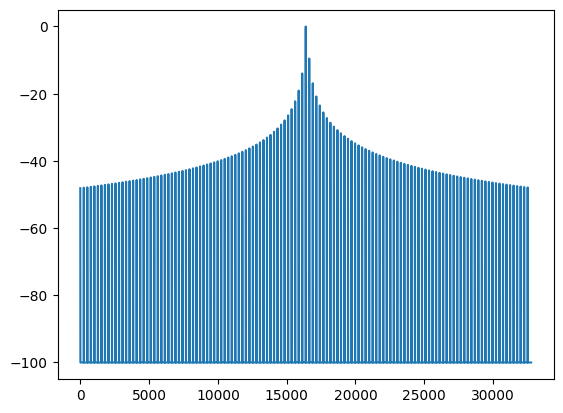

In [34]:
max_id = np.argmax(expected_to_fail.impulse_results[1].signal_power_db)

plt.plot(expected_to_fail.impulse_results[1].signal_power_db[max_id - 16384 : max_id + 16384])
plt.show()